In [1]:
from pdrtpy.modelset import ModelSet
import numpy as np
from astropy.table import Table
import pdrtpy.pdrutils as utils
from pdrtpy.plot.lineratioplot import LineRatioPlot
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy import version
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from labellines import labelLine, labelLines
from lmfit import Model, Parameters, Minimizer, minimize, fit_report
import corner
import matplotlib.pyplot as plt
%matplotlib inline

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1161: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
#m.table.show_in_notebook()

In [3]:
m = ModelSet(name="wk2006",z=1)

In [4]:
m.supported_ratios


title,ratio label
str51,str19
[O I] 145 $\mu$m / [O I] 63 $\mu$m,OI_145/OI_63
[O I] 145 $\mu$m / [C II] 158 $\mu$m,OI_145/CII_158
[O I] 63 $\mu$m / [C II] 158 $\mu$m,OI_63/CII_158
[C II] 158 $\mu$m / [C I] 609 $\mu$m,CII_158/CI_609
[C I] 370 $\mu$m / [C I] 609 $\mu$m,CI_370/CI_609
[C II] 158 $\mu$m / CO(J=1-0),CII_158/CO_10
[C II] 158 $\mu$m / CO(J=3-2),CII_158/CO_32
[C II] 158 $\mu$m / CO(J=6-5),CII_158/CO_65
[C II] 158 $\mu$m / I$_{FIR}$,CII_158/FIR


In [5]:
mp = ModelPlot(m)
'H264Q11/H210S1' in m.table['ratio']

Habing


True

In [6]:
try:
    m.model_ratios(["CII_158"])
except Exception as e:
    print("caught exception properly:",e)

mz = m.get_model('CII_158/CI_609')
mz.data.max()

caught exception properly: m most contain at least two strings


7066.33

In [7]:
np.squeeze(None)

array(None, dtype=object)

[[ 9.01887035  0.39307201]
 [44.43040085 19.76740074]]
[9.01887035]
[8.60261744]
[7066.33007812]


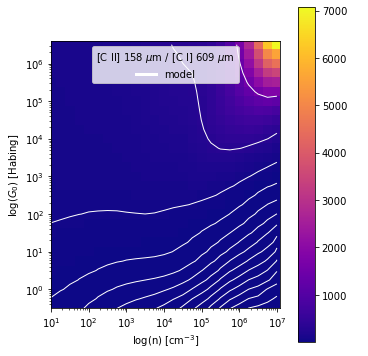

In [8]:
print(mz.get([3,1],[1,-.5],log=True))
print(mz.get(10,10**-.5,log=False))
mp.plot(mz.id)
mz.wcs
10**-.5
print(mz.get(1.1,-.45,log=True))
print(mz.get(1E7,10**6.5))
#print(mz[0,0])

In [9]:
mz.is_ratio()

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [10]:
# only residual not residual squared
def residual_single_pix(params,models,measurements):
    parvals = params.valuesdict()
    
    mvalue = np.empty(len(models))
    dvalue = np.empty(len(measurements))
    evalue = np.empty(len(measurements))
    i=0
    for k in models:
        mvalue[i] = models[k].get(parvals['density'],parvals['radiation_field']) 
        dvalue[i] = measurements[k].value
        evalue[i] = measurements[k].error
        i = i+1
    return  (dvalue - mvalue)/evalue


In [11]:
try:
    m.get_models(['CII_158'],model_type='foo')
except ValueError as e:
    print("caught exception properly ",e)
x=m.get_models(["CI_609","FIR"],model_type="ratio")
y=m.get_models(["CI_609","FIR"],model_type="intensity")
z=m.get_models(["CI_609","FIR"],model_type="both")
q=m.get_models(['CII_158'],model_type='intensity')

caught exception properly  Unrecognized model_type: must be one of 'intensity', 'ratio', or 'both'


In [12]:
myunit = "erg s-1 cm-2 sr-1"
mx=Measurement(data=[1.5E-6],uncertainty = StdDevUncertainty([0.5E-6]),identifier="CI_609",unit=myunit)
mm = Measurement(data=1.5E-6,uncertainty = StdDevUncertainty(0.5E-6),identifier="CI_609",unit=myunit)
#my=Measurement(data=[2],uncertainty = StdDevUncertainty(1),identifier="CII_158/CI_609",unit=u.dimensionless_unscaled)
#mz=Measurement(data=[9E-6],uncertainty = StdDevUncertainty(1E-6),identifier="CII_158",unit=myunit)
#mq=Measurement(data=[3E-6],uncertainty=StdDevUncertainty(1E-7),identifier="OI_145",unit=myunit)
#a=[mx,my,mq,mz]
#ids = [m.id for m in a]
#d = dict(zip(ids,a))
#print("dict:",d)
#print(type(d["CI_609"]))
#d["CI_609"].levels
#mp.overlay(a,shading=.71)
#len(mx.data)
#q[1].id
print(type(mx.data),type(mm.data))
print(np.shape(mx.data),np.shape(mm.data))
#np.shape(mm.data) == ()
#np.array([mm.data])
#mm.data[0]
#np.shape(mx.data)
print(np.shape(mx.error),np.shape(mm.error))
len(np.array([3,2,1]))
mm.size==1

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1,) (1,)
(1,) (1,)


True

In [13]:
from astropy.nddata import CCDData
foo = CCDData(data=np.array([[4,5,3],[1,2,3]]),uncertainty=StdDevUncertainty([1,2,3]),unit="K")
len(foo.data)

2

In [14]:
a = np.array(1)
b = np.array([1])
print(a.size,b.size)
print(a.itemsize,b.itemsize)
print(a.shape,b.shape)

1 1
8 8
() (1,)


In [15]:
myunit = "erg s-1 cm-2 sr-1" # my default unit for value and error
m1 = Measurement(data=6E-6,uncertainty = StdDevUncertainty(1E-6),identifier="OI_145",unit=myunit)
m2 = Measurement(data=2.2E-6,uncertainty = StdDevUncertainty(5E-7),identifier="CI_609",unit=myunit)
m3 = Measurement(data=260.0,uncertainty = StdDevUncertainty(40.0),identifier="CO_21",restfreq="230.538 GHz", unit="K km/s")
m4 = Measurement(data=2E-5,uncertainty = StdDevUncertainty(2E-6),identifier="CII_158",unit=myunit)
m5 = Measurement(data=300,uncertainty=StdDevUncertainty(30),identifier="CO_43",restfreq="461.04 GHz" ,unit="K km/s")
aa = [m1,m2,m3,m4,m5]


Converting K km/s to erg / (cm2 s sr) using Factor = +1.256E-08 g / (cm K s2)
Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)
Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)
Converting K km/s to erg / (cm2 s sr) using Factor = +1.256E-08 g / (cm K s2)
fixheader modelnaxis 2 naxis 3
fixheader modelnaxis 2 naxis 3
dict_keys(['OI_145/CII_158', 'CI_609/CO_21', 'CI_609/CO_43', 'CII_158/CI_609', 'CO_43/CO_21'])
316227.7660168379 +/- nan 1 / cm3 56.23413251903491 +/- nan Habing
Habing
4.49805929234543


(29, 25)

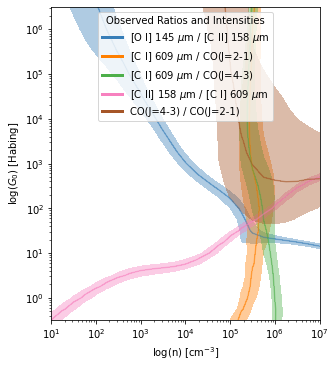

In [18]:
lrf = LineRatioFit(m,aa)
lrf.run()
print(lrf._modelratios.keys())
print(lrf.density,lrf.radiation_field)
par = Parameters()
par.add('density',min=10,max=1E7,value=1E4)
par.add('radiation_field',min=1,max=1E6,value=1000)
lrp = LineRatioPlot(lrf)
lrp.overlay_all_ratios()
#lrp.chisq()
print(np.min(lrf._chisq))
lrf._chisq.header
np.squeeze(lrf._chisq).shape

In [ ]:
lrf._measurementnaxis
len(m1.shape)

In [ ]:
par.pretty_print()

In [ ]:
lrf.compute_density_radiation_field2()
len(lrf._fitresult)
print(fit_report(lrf._fitresult[0]))
lrf._fitresult[0].__dict__
lrf._reduced_chisq_min

In [ ]:
print(lrf._density,lrf._radiation_field,lrf._chisq_min,lrf._reduced_chisq_min)
print(lrf._d2,lrf._rf2,lrf._chi2,lrf._rchi2)

In [ ]:
lrf._density.value.flatten()

In [ ]:
lrf._modelratios['OI_145/CII_158'].header['CUNIT2']
ss=list(lrf._modelratios.keys())
print(ss[0])
print([i.find('CO') for i in ss])
#ss.index("CO")
[idx for idx, s in enumerate(ss) if 'CO' in s][0]
lrf._modelratios['OI_145/CII_158'].size

In [ ]:
mw = ModelSet('wk2020',z=1)
tt = mw.get_model('OI_145/CII_158')
print(tt.header['CUNIT2'])
u.Unit(tt.header['CUNIT2']) == utils._RFS_UNIT_
x,y=utils.get_xy_from_wcs(tt,linear=True)
x[0],y[0]
x[48],x[-1]
y[56],y[-1],y.size

In [ ]:
par.add('density',min=10,max=1E7,value=1E4)
par.add('radiation_field',min=1,max=1E6,value=1000)
method='powell'
if True:
    x=residual_single_pix(par,lrf._modelratios,lrf._observedratios)
    print(x)
    len(lrf._modelratios)
    res=minimize(residual_single_pix,params=par,method=method,args=(lrf._modelratios,lrf._observedratios))
    #res2=minimize(residual_single_pix,params=par,workers=4,method='emcee',is_weighted=True,burn=300,steps=5000,args=(lrf._modelratios,lrf._observedratios))
    print(fit_report(res))
    #print(fit_report(res2))
#res.__dict__
type(res)

In [ ]:
def transform_data(lrf):
    #mvalue = np.zeros(np.insert(values=lrf.ratiocount,arr=lrf._modelshape,obj=2))
    mvalue = np.moveaxis(np.array([lrf._modelratios[k].data for k in lrf._modelratios]),source=[0],destination=[2])
    dvalue = np.array([lrf._observedratios[k].data for k in lrf._observedratios])
    evalue = np.array([lrf._observedratios[k].error for k in lrf._observedratios])
    print("shapes mde ",np.shape(mvalue),np.shape(dvalue),np.shape(evalue))
    return np.sum(((mvalue-dvalue)/evalue)**2,axis=2)
np.min(transform_data(lrf))
#print(np.array([lrf._modelratios[k].data for k in lrf._modelratios]).shape)
#print(np.shape(np.moveaxis(np.array([lrf._modelratios[k].data for k in lrf._modelratios]),source=[0],destination=[2])))
#print(lrf._modelshape)

In [ ]:
# Get the input filenames of the FITS files in the testdata directory
# utils.get_testdata() is a special method to locate files there.
# These are maps from Jameson et al 2018.
print("Test FITS files are in: %s"%utils.testdata_dir())
cii_flux = utils.get_testdata("n22_cii_flux.fits")  # [C II] flux
cii_err = utils.get_testdata("n22_cii_error.fits")  # [C II] error
oi_flux = utils.get_testdata("n22_oi_flux.fits")    # [O I] flux 
oi_err = utils.get_testdata("n22_oi_error.fits")    # [O I] error
FIR_flux = utils.get_testdata("n22_FIR.fits")       # FIR flux

# Output file names
cii_combined = "n22_cii_flux_error.fits"
oi_combined = "n22_oi_flux_error.fits"
FIR_combined = "n22_FIR_flux_error.fits"

# create the Measurements and write them out as FITS files with two HDUs.
# Set overwrite=True to allow multiple runs of this notebook.
Measurement.make_measurement(cii_flux, cii_err, cii_combined,overwrite=True)
Measurement.make_measurement(oi_flux, oi_err, oi_combined,overwrite=True)
# Assign a 10% error in FIR flux
Measurement.make_measurement(FIR_flux, error='10%', outfile=FIR_combined,overwrite=True)

# Read in the FITS files to Measurements
cii_meas = Measurement.read(cii_combined, identifier="CII_158")
FIR_meas = Measurement.read(FIR_combined, identifier="FIR")
oi_meas = Measurement.read(oi_combined, identifier="OI_63")

In [ ]:
bb = [cii_meas,FIR_meas,oi_meas]
lrb = LineRatioFit(m,bb)
lrb.run()
deflevels = lrp._autolevels(lrf._chisq.data)

In [ ]:
np.shape(transform_data(lrf))

In [ ]:
transform_data(lrb)

In [ ]:
xxx=transform_data(lrf)
plt.contour(xxx,levels=deflevels)

In [ ]:
zvalue = np.array([lrb._modelratios[k].data for k in lrb._modelratios])
mvalue = np.moveaxis(zvalue,source=[0],destination=[2])
#mvalue = mvalue[:,:,np.newaxis]
dvalue = np.array([lrb._observedratios[k].data for k in lrb._observedratios])
evalue = np.array([lrb._observedratios[k].error for k in lrb._observedratios])
print("shapes mde ",np.shape(mvalue),np.shape(dvalue),np.shape(evalue))

In [ ]:
foo=np.swapaxes(dvalue.reshape(3,139*81),0,1)
eoo=np.swapaxes(evalue.reshape(3,139*81),0,1)
print("data error",foo.shape,eoo.shape)
mfoo = mvalue[:,:,None,:]
print("M ",mfoo.shape)
#mvalue[None,None,:] - dvalue
what = ((mfoo - foo)/eoo)**2
print("W ",what.shape)
testchi = what.sum(axis=3).reshape(29,25,139,81)
print("TC ",testchi.shape)
ttchi = np.amin(testchi,(0,1))
np.nanmin(ttchi), np.nanmax(ttchi)
tr = testchi.reshape(29*25,139,81)
print(tr.shape)
ttchi = np.amin(tr,0)
ttchi.shape

In [ ]:
plt.imshow(ttchi,origin='lower',norm=None,cmap='rainbow')
plt.colorbar()

In [ ]:
X=np.array([[5, 5, 4],
       [8, 1, 8],
       [0, 1, 5],
       [0, 3, 1],
       [6, 2, 5]])
w = np.array([[8, 5, 1],
       [7, 8, 6]])

In [ ]:
np.nanmin(lrb._chisq_min)
np.nanmax(lrb._chisq_min)

In [ ]:
plt.imshow(dvalue[2])

In [ ]:
chisq = ((mvalue - dvalue.T)/evalue.T)**2

chi2 = np.sum(chisq,axis=4)
print(np.shape(chi2.T))
print(np.nanmin(chi2))
chimin = np.amin(chi2,(0,1))
print(np.shape(chimin.T))
plt.imshow(chimin.T,cmap='rainbow',norm=None,origin='lower')
plt.colorbar()

In [ ]:
v = LineRatioPlot(lrb)
v.chisq(contours=False,norm=None,cmap='rainbow')

In [ ]:
np.array(np.insert(values=int(lrf.ratiocount),arr=lrf._observedshape,obj=len(lrf._observedshape)),dtype=np.int)
#type(lrf.ratiocount)

In [ ]:
mvalue = 0.1*np.arange(30).reshape(5,6)
ncol=3
nrow=2
nval=4
size=nval*nrow*ncol
dvalue = 0.1*np.arange(size).reshape([nval,ncol,nrow])
print(dvalue,"\n")
print(mvalue,"\n")
evalue = 1*np.ones([nval,ncol,nrow])
np.shape(mvalue)
sum = 0
residuals = list()#np.empty(mvalue.shape).flatten()
accum = list()
print("resid shape ",np.shape(residuals))
for i in range(nval):
    residuals=list()
    for m in mvalue.flatten():
        _z=((dvalue[i]-m)/evalue[i])**2
        #print("z=",_z)
        residuals.append(_z)
    accum.append(residuals)
#    for m in mvalue.flatten():
#        #print(m)
#        residuals.append(((dvalue[i]-m)/evalue[i])**2)
print("resid shape ",np.shape(residuals))
print("accum shape",np.shape(accum))
newshape=np.hstack((mvalue.shape,(3,2)))
print(newshape)
if True:
    #np.shape(residuals)
    rs =np.reshape(accum,(nval,5,6,ncol,nrow))
    #print(rs)
    #xx=((dvalue-5.0)/evalue)**2
    #print("XX=",xx,xx.shape)
    #xxs=np.sum(xx,axis=0)
    #print("XXS ",xxs)
    print(rs.shape)
    chi=np.sum(rs,axis=0)
    print("CHI ",chi)

In [ ]:
foo=np.swapaxes(dvalue.reshape(4,6),0,1)
eoo=np.swapaxes(evalue.reshape(4,6),0,1)

In [ ]:
emcee_plot = corner.corner(res2.flatchain, 
                           truths=list(res2.params.valuesdict().values()),
                          show_titles=True,
                           labels=[r"$n [{\rm cm}^{-3}]$",r"$G_0$ [Habing]"],
                           title_fmt='.2e',use_math_text=True,range=[.9995,1])

In [ ]:
mp.plot("CI_609",image=True)#measurements=[mx],image=False,legend=True,contours=True,label=True)

In [ ]:
mp.plot("CI_609/FIR",image=True,measurements=[mx],legend=True,label=True)

In [ ]:
#mp.plot("CI_609/FIR",image=True,measurements=[mx,my],legend=True,yaxis_unit=u.erg/(u.second*u.cm*u.cm),label=False)

In [ ]:
l = LineRatioFit(m,[mx])

In [ ]:
p = LineRatioPlot(l)

In [ ]:
l.modelset.supported_ratios.show_in_notebook()

In [ ]:
p.modelintensity("CI_609",measurements=[mx],legend=True,xaxis_unit="m-3",contours=True,label=True)

In [ ]:
identifiers1 = ["OI_63+CII_158/FIR","OI_63/CII_158"]
identifiers2 = ["CO_21","OI_63"]
identifiers3 = ["CO_65","CI_609/CO_43"]

In [ ]:
mp.phasespace(identifiers2,reciprocal=[False,False],dens_clip=[100,1E6]*u.Unit("cm-3"),rad_clip=[1,1E4]*utils._RFS_UNIT_)
#mp.savefig("OI_CO21.png",bbox_inches='tight',facecolor='white')

In [ ]:
A1 = np.array([1, 2, 2, 2, 3, 3, 7])
A2 = np.array([0.5, 1, 1.5, 2, 7, 2, 6.9])
err_bars = np.array([0.1, 0.6, 0.9, 0.2, 0.01, 0.8, 0.1])

def chisq(obs, exp, error):
    return (obs - exp) ** 2 / (error ** 2)

print(chisq(A1, A2, err_bars))

In [ ]:
help(mp.overlay)

In [ ]:
a1 = np.sum([lrf._deltasq[r]._data for r in lrf._deltasq],axis=0)

In [ ]:
a2 = sum([lrf._deltasq[r]._data for r in lrf._deltasq])

In [ ]:
np.all(a1 == a2)

In [ ]:
from scipy.stats import chisquare, power_divergence

In [ ]:
keys = list(lrf._modelratios.keys()) 
print(keys)
mods = np.array([lrf._modelratios[r]._data for r in keys])
dats = np.array([lrf._observedratios[r]._data for r in keys])
errs = np.array([lrf._observedratios[r].error for r in keys])


mods=np.moveaxis(mods,source=[0],destination=[2])
#mods = mods[:,:,np.newaxis,np.newaxis]
print(np.shape(mods))
chichi = ((dats - mods)/errs)**2
mods = mods/errs
dats = dats/errs
chiorig=np.sum(chichi,axis=2)
plt.imshow(chiorig)
mods = np.sqrt(mods)*mods
dats = np.sqrt(mods)*dats

In [ ]:
plt.contour(chiorig,levels=deflevels)
plt.axis('equal')

In [ ]:
chi,p=chisquare(dats,mods,axis=2)
np.shape(chi)

In [ ]:
norm = lrp._zscale(chi,vmin=0,vmax=1E8,stretch='log')
plt.imshow(chi,origin='lower',norm=norm)
plt.colorbar()

In [ ]:
chi1,p1 = power_divergence(dats,mods,axis=2,lambda_='pearson')

In [ ]:
norm = lrp._zscale(chi1,vmin=chi1.min(),vmax=chi1.max(),stretch='linear')
plt.imshow(chi1,origin='lower',norm=norm)
plt.colorbar()

In [ ]:
type(chi)

In [ ]:
plt.contour(chi,origin='lower',levels=deflevels)
plt.axis('equal')

In [ ]:
plt.contour(chi1,origin='lower',levels=deflevels)
plt.axis('equal')

In [ ]:
plt.contour(chiorig,origin='lower',levels=deflevels)
plt.axis('equal')

In [ ]:
norm = lrp._get_norm('simple',p1,vmin=p1.min(),vmax=p1.max(),stretch='log')
plt.imshow(p1,origin='lower',norm=norm)
plt.colorbar()

In [ ]:
lrp.chisq(colorbar=True)
deflevels = lrp._autolevels(lrf._chisq.data)

In [ ]:
plt.contourf(chi-chiorig)
plt.colorbar()

In [ ]:
np.sqrt(mods).max()